# Testing False Positives of Benign Flight
This notebook looks at false positive rates in the benign case by using the
Leave One Out approach.
The final result was to use the maximum disagreement over the full set of
Benign missions during testing against spoofing.

The data files can be found in the data subdirectory. Only interim data will be
available on github to preserve storage. For raw log files please contact me at
xxxxxxx.

# Optical Flow and GPS Velocity

## Loading Data and Parsing Error Margins

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

import pandas as pd
import numpy as np
from confirmation.process import process_SNS
from os.path import exists
from confirmation.process import geodetic2ned, change_in_signal
from confirmation.process import length, body_to_earth2D, low_pass_filter
from confirmation.process import signal_match_and_cumsum

#Data used for comparisons later
max_errors = []
errors_north = []
errors_east = []
total_diff = []

#Convert log file from Mission Planner to usable CSV
data_dir = "../data/"
files = ["Benign (" + str(x) + ").log" for x in range(1, 6)] #list of files to process

for file in files:
    output = data_dir + "interim/" + file[:-3] + "csv"

    #Check if file exists already and if it does skip processing and read the file
    if not exists(output):
        #Open log file and parse out the SNS data into pandas dataframes
        df = process_SNS(data_dir + "raw/" + file, output)
    else:
        df = pd.read_csv(output)

    #All of the data is numeric and should be treated as such
    df = df.apply(pd.to_numeric)

    #Set index to be the timestamps so we can drop duplicate rows
    #then reset index to be row number
    df.set_index("TimeUS",inplace=True)
    df = df.drop_duplicates()
    df.reset_index(inplace=True)

    #Get rid of duplicate rows and convert timestamps to datetime
    ofMS = df[df.ofMS.shift() != df.ofMS][["ofMS","frF","frR","brF","brR", "rf", "m00", "m10"]].reset_index()
    ofMS['ofMS'] = pd.to_datetime(ofMS['ofMS'], unit='ms')
    gpsMS = df[df.gpsMS.shift() != df.gpsMS][["gpsMS","lat","lng","gpAlt", "m00", "m10"]].reset_index()
    gpsMS['gpsMS'] = pd.to_datetime(gpsMS['gpsMS'], unit='ms')
    rfMS = df[df.rfMS.shift() != df.rfMS][["rfMS","rf","m22"]].reset_index(drop=True)
    rfMS['rfMS'] = pd.to_datetime(rfMS['rfMS'], unit='ms')
    
    #GPS Velocity
    gps = geodetic2ned(gpsMS.lat, gpsMS.lng, gpsMS.gpAlt)
    gps_north = (gps.North.diff().fillna(0)/(gpsMS.gpsMS.diff().dt.total_seconds()))[1:].reset_index(drop=True)
    gps_east = (gps.East.diff().fillna(0)/(gpsMS.gpsMS.diff().dt.total_seconds()))[1:].reset_index(drop=True)
    gps_down = (gps.Down.diff().fillna(0)/100/(gpsMS.gpsMS.diff().dt.total_seconds()))[1:].reset_index(drop=True)

    gps_east = pd.Series(gps_east)
    gps_north = pd.Series(gps_north)
    
    #Convert optical flow and rangefinder to OF Velocity in body frame
    of_vel_bf = pd.DataFrame(data={"OF Forward":(ofMS.frF - ofMS.brF) * ofMS.rf/100,
                                   "OF Right":(ofMS.frR - ofMS.brR) * ofMS.rf/100})
    earth_frame = body_to_earth2D(of_vel_bf["OF Forward"], of_vel_bf["OF Right"], ofMS.m00, ofMS.m10)
    
    lpf_E = -low_pass_filter(earth_frame.East, alpha=0.2)
    lpf_N = low_pass_filter(earth_frame.North, alpha=0.2)
    
    gps_east = pd.Series(gps_east)
    lpf_E = pd.Series(lpf_E)
    gps_north = pd.Series(gps_north)
    lpf_N = pd.Series(lpf_N)
    
    #Matching OF to the GPS update rate
    of_east = signal_match_and_cumsum(ofMS.ofMS.diff().dt.total_seconds().fillna(0).cumsum()[1:].reset_index(drop=True), change_in_signal(lpf_E),
                                      gpsMS.gpsMS.diff().dt.total_seconds().fillna(0).cumsum(), gps_east)
    of_east = pd.Series(of_east, name="OF East, LPF")
    of_north = signal_match_and_cumsum(ofMS.ofMS.diff().dt.total_seconds().fillna(0).cumsum()[1:].reset_index(drop=True), change_in_signal(lpf_N),
                                       gpsMS.gpsMS.diff().dt.total_seconds().fillna(0).cumsum(), gps_north)
    of_north = pd.Series(of_north, name="OF North, LPF")
    
    diff_east = abs(gps_east - of_east)
    diff_north = abs(gps_north - of_north)
    diff = pd.Series([((x**2) + (y**2))**(1/2) for x,y in zip(diff_east, diff_north)])
    max_errors.append(np.nanmax(diff))
    errors_north.append(diff_north)
    errors_east.append(diff_east)
    total_diff.append(diff)

## Error Margin from 4 flights, Test on 1

In [2]:
#key is the mission being tested by error derived from the other 4
false_positives = {0:0,
                   1:0,
                   2:0,
                   3:0,
                   4:0}

for error in range(len(max_errors)):
    max_bound = 0
    for others in range(len(max_errors)): #Find the largest error amongst the other 4 tests
        if others == error:
            continue
        max_bound = max(max_bound, max_errors[others])
    false_positives[error] = len(total_diff[error][total_diff[error] >= max_bound])/len(total_diff[error])

In [3]:
false_positives

{0: 0.0, 1: 0.007722007722007722, 2: 0.0, 3: 0.0, 4: 0.0}

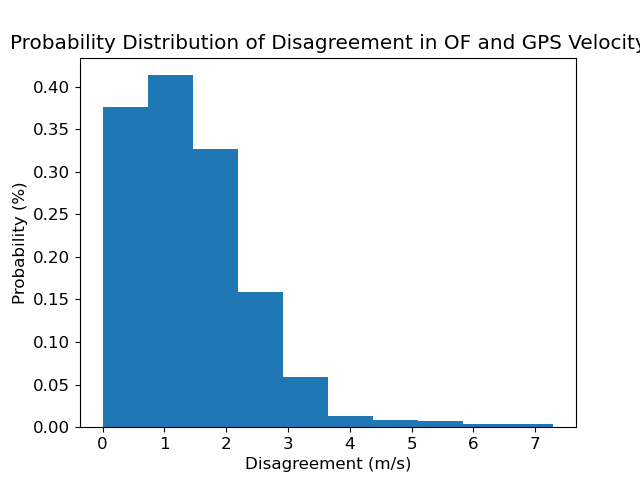

In [4]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size':12})
plt.figure(1)
plt.hist(pd.concat(total_diff), density=True)
plt.title("Probability Distribution of Disagreement in OF and GPS Velocity")
plt.xlabel("Disagreement (m/s)")
plt.ylabel("Probability (%)")
plt.show()

# Gyroscope Yaw and GPS Ground Course

In [5]:
from math import degrees, atan2
from confirmation.process import trap_integrate, diff

#Data used for comparisons later
max_errors = []
total_diff = []

#Valid mission times since GPS isn't usable unless in flight
timings = [[237000000, 281000000],
           [86000000, 121000000],
           [108000000,152000000],
           [247000000,284000000],
           [101000000,145000000]]

#Convert log file from Mission Planner to usable CSV
data_dir = "../data/"
files = ["Benign (" + str(x) + ").log" for x in range(1, 6)] #list of files to process

for index in range(len(files)):
    file = files[index]
    output = data_dir + "interim/" + file[:-3] + "csv"

    #Check if file exists already and if it does skip processing and read the file
    if not exists(output):
        #Open log file and parse out the SNS data into pandas dataframes
        df = process_SNS(data_dir + "raw/" + file, output)
    else:
        df = pd.read_csv(output)

    #All of the data is numeric and should be treated as such
    df = df.apply(pd.to_numeric)

    #Set index to be the timestamps so we can drop duplicate rows
    #then reset index to be row number
    df = df[(df.TimeUS >= timings[index][0]) & (df.TimeUS <= timings[index][1])]
    df.set_index("TimeUS",inplace=True)
    df = df.drop_duplicates()
    df.reset_index(inplace=True)

    #Get rid of duplicate rows and convert timestamps to datetime
    cUS = df[df.cUS.shift() != df.cUS][["cUS","gyrx","gyry","gyrz","CAN","CAE","CAD","rCAN","rCAE","rCAD", "CVN", "CVE", "CVD"]].reset_index()
    cUS['cUS'] = pd.to_datetime(cUS['cUS'], unit='us')
    gpsMS = df[df.gpsMS.shift() != df.gpsMS][["gpsMS","lat","lng","gpAlt", "m00", "m10"]].reset_index()
    gpsMS['gpsMS'] = pd.to_datetime(gpsMS['gpsMS'], unit='ms')
    
    #GPS Velocity
    gps = geodetic2ned(gpsMS.lat, gpsMS.lng, gpsMS.gpAlt)
    gps_north = (gps.North.diff().fillna(0)/(gpsMS.gpsMS.diff().dt.total_seconds()))[1:].reset_index(drop=True)
    gps_east = (gps.East.diff().fillna(0)/(gpsMS.gpsMS.diff().dt.total_seconds()))[1:].reset_index(drop=True)
    gps_down = (gps.Down.diff().fillna(0)/100/(gpsMS.gpsMS.diff().dt.total_seconds()))[1:].reset_index(drop=True)

    gps_east = pd.Series(gps_east)
    gps_north = pd.Series(gps_north)

    #GPS derived ground course
    gps_gc = []
    for reading in range(len(gps_north)):
        gps_gc.append(degrees(atan2(gps_east[reading], gps_north[reading])) % 360)
    gps_gc = pd.Series(gps_gc, name="GPS Ground Course")

    #Matching gyroscope to the GPS update rate
    gyr_heading = trap_integrate(cUS.cUS.diff().dt.total_seconds().fillna(0).cumsum(), cUS.gyrz).apply(degrees).cumsum() % 360
    gyr_gps_heading = signal_match_and_cumsum(cUS.cUS.diff().dt.total_seconds().fillna(0).cumsum()[2:].reset_index(drop=True), change_in_signal(gyr_heading),
                                              gpsMS.gpsMS.diff().dt.total_seconds().fillna(0).cumsum(), gps_gc)
    gyr_gps_heading = pd.Series(gyr_gps_heading, name="Gyroscope Heading")
    
    #Start both signals at 0 to align them
    gps_gc = (gps_gc - gps_gc[0]) % 360
    gyr_gps_heading = (gyr_gps_heading - gyr_gps_heading[0])%360

    angle_diff = abs(diff(gps_gc[1:].reset_index(drop=True), gyr_gps_heading, wrap=True))
    max_errors.append(np.nanmax(angle_diff))
    total_diff.append(angle_diff)

In [6]:
max_errors

[13.963222381629436,
 9.802613871891424,
 11.192658744241498,
 13.242882067339167,
 10.1471880109533]

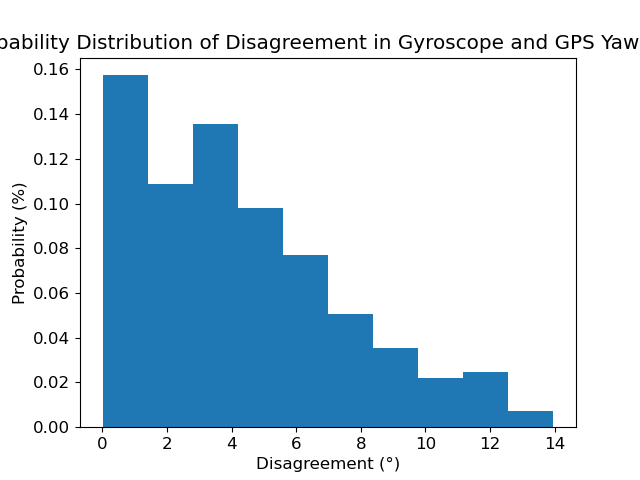

In [7]:
plt.figure(2)
plt.hist(pd.concat(total_diff), density=True)
plt.title("Probability Distribution of Disagreement in Gyroscope and GPS Yaw Rate")
plt.xlabel("Disagreement (°)")
plt.ylabel("Probability (%)")
plt.show()